# 개 - 고양이 이미지 분류

In [1]:
!cp drive/MyDrive/Colab/cat_dog.zip .

In [2]:
!unzip -qq cat_dog.zip -d cat_dog

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import pandas as pd

In [4]:
seed = 2021
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
IMG_SIZE = 128
IMG_CHANNELS = 3
BATCH_SIZE=32

In [6]:
filenames = os.listdir('cat_dog/train')
species_code = []
for filename in filenames:
  species = filename.split('.')[0]
  if species == 'dog':
    species_code.append(0)
  else:
    species_code.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'species': species_code
})

df.head()

,filename,species
0,dog.8949.jpg,0
1,cat.1062.jpg,1
2,dog.6008.jpg,0
3,dog.6540.jpg,0
4,dog.9429.jpg,0


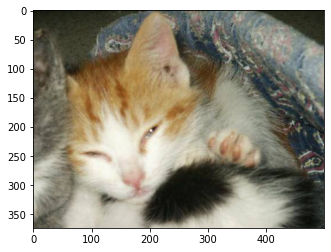

In [7]:
import random
sample = random.choice(filenames)
temp_img = load_img('cat_dog/train/' + sample)
plt.imshow(temp_img);

In [8]:
model = Sequential([
                    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, IMG_CHANNELS)),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.25),
                    Conv2D(64, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.25),
                    Conv2D(128, (3, 3), activation='relu'),
                    BatchNormalization(),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.25),
                    Flatten(),
                    Dense(512, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(2, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [9]:
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
earlystop = EarlyStopping(patience=10)

In [11]:
df['species'] = df['species'].replace({0: 'dog', 1: 'cat'})

from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=seed)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

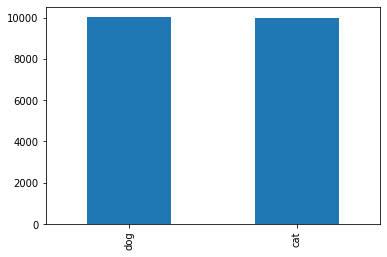

In [12]:
train_df['species'].value_counts().plot.bar()

In [13]:
train_df.shape, valid_df.shape

((20000, 2), (5000, 2))

In [14]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory='cat_dog/train/',
    x_col='filename',
    y_col='species',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 20000 validated image filenames belonging to 2 classes.


In [15]:
valid_datagen = ImageDataGenerator(rescale=1. / 255)
valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    'cat_dog/train/',
    x_col='filename',
    y_col='species',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 5000 validated image filenames belonging to 2 classes.


In [16]:
history = model.fit_generator(train_generator, epochs=50, validation_data=valid_generator, callbacks=[learning_rate_reduction, earlystop])

109/625 [====>.........................] - ETA: 1:40 - loss: 0.2629 - accuracy: 0.8862

KeyboardInterrupt: ignored